<a href="https://colab.research.google.com/github/hyulianton/JaringanSyarafTiruan/blob/main/jst_Deteksi_Anomali_dengan_Autoencoder.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 🕵️ Deteksi Anomali dengan Autoencoder

Deteksi Anomali adalah proses mengidentifikasi *pola yang tidak biasa* atau *outlier* dalam suatu dataset.

Dalam contoh ini, kita akan menggunakan **Autoencoder**, sebuah jenis jaringan saraf yang sangat baik untuk tugas ini. Autoencoder dilatih untuk merekonstruksi data **normal** dengan baik. Jika model disodorkan data **anomali**, ia akan gagal merekonstruksinya, menghasilkan **kesalahan rekonstruksi (reconstruction error)** yang tinggi.

**Strategi Kita:**
1.  Latih Autoencoder *hanya* pada gambar **T-shirt/Top** (kelas 0). Ini adalah data *normal* kita.
2.  Tentukan ambang batas (threshold) dari kesalahan rekonstruksi data normal.
3.  Uji model pada T-shirt (normal) dan **Ankle Boot** (kelas 9, anomali).

## 1. Persiapan dan Impor Pustaka

Langkah pertama adalah mengimpor semua pustaka yang diperlukan. Kita akan menggunakan **TensorFlow/Keras** untuk membuat model jaringan saraf dan **Matplotlib** untuk visualisasi.

In [1]:
# Import Pustaka
import numpy as np
import tensorflow as tf
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error

## 2. Pemuatan dan Pra-pemrosesan Data

Kita akan memuat dataset Fashion MNIST. Setiap gambar berukuran 28x28 piksel.


### 2.1. Memuat Dataset

In [2]:
# Memuat dataset Fashion MNIST
(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

# Normalisasi: Skalakan nilai piksel dari 0-255 menjadi 0-1
x_train = x_train.astype('float32') / 255.0
x_test = x_test.astype('float32') / 255.0

# Flatten (Ratakan) gambar dari 28x28 menjadi vektor 784
x_train_flat = x_train.reshape((len(x_train), np.prod(x_train.shape[1:])))
x_test_flat = x_test.reshape((len(x_test), np.prod(x_test.shape[1:])))

# Ukuran input
input_size = x_train_flat.shape[1]
print(f"Ukuran Input (Vektor): {input_size}")

29515/29515 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
26421880/26421880 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
5148/5148 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
4422102/4422102 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Ukuran Input (Vektor): 784


### 2.2. Pemisahan Data Normal dan Anomali

Kita akan mendefinisikan **Kelas 0 (T-shirt/Top)** sebagai data **NORMAL** dan **Kelas 9 (Ankle boot)** sebagai data **ANOMALI** untuk pengujian.

In [3]:
# Kelas 0: T-shirt/Top (NORMAL)
NORMAL_CLASS = 0
# Kelas 9: Ankle boot (ANOMALI)
ANOMALY_CLASS = 9

# 1. Data Training (Hanya data NORMAL)
x_train_normal = x_train_flat[y_train == NORMAL_CLASS]

# 2. Data Testing (Normal dan Anomali)
x_test_normal = x_test_flat[y_test == NORMAL_CLASS]
x_test_anomaly = x_test_flat[y_test == ANOMALY_CLASS]

print(f"\nJumlah Data Training Normal: {len(x_train_normal)}")
print(f"Jumlah Data Test Normal: {len(x_test_normal)}")
print(f"Jumlah Data Test Anomali: {len(x_test_anomaly)}")


Jumlah Data Training Normal: 6000
Jumlah Data Test Normal: 1000
Jumlah Data Test Anomali: 1000


## 3. Mendefinisikan Model Autoencoder

Autoencoder terdiri dari dua bagian: **Encoder** (memampatkan data menjadi representasi yang lebih kecil, disebut *latent space*) dan **Decoder** (merekonstruksi data dari *latent space* kembali ke bentuk aslinya).


In [4]:
# --- Parameter Model ---
latent_dim = 32  # Ukuran Latent Space (ruang terkompresi)
hidden_layer_1 = 128
hidden_layer_2 = 64

# --- ENCODER ---
input_layer = Input(shape=(input_size,))
# Lapisan tersembunyi
encoded = Dense(hidden_layer_1, activation='relu')(input_layer)
encoded = Dense(hidden_layer_2, activation='relu')(encoded)
# Latent Space
latent_space = Dense(latent_dim, activation='relu')(encoded)

# --- DECODER ---
decoded = Dense(hidden_layer_2, activation='relu')(latent_space)
decoded = Dense(hidden_layer_1, activation='relu')(decoded)
# Lapisan Output (harus sama dengan ukuran input)
output_layer = Dense(input_size, activation='sigmoid')(decoded) # Sigmoid karena output 0-1

# --- Model Autoencoder ---
autoencoder = Model(input_layer, output_layer)

# Kompilasi model
# Loss: Mean Squared Error (MSE) standar untuk rekonstruksi
autoencoder.compile(optimizer='adam', loss='mse')

# Ringkasan model
autoencoder.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 784)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │       100,480 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 64)             │         2,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 128)            │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 784)            │       101,136 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 222,384 (868.69 KB)

 Trainable params: 222,384 (868.69 KB)

 Non-trainable params: 0 (0.00 B)

## 4. Pelatihan Model

Kita hanya melatih model menggunakan data **NORMAL** (`x_train_normal`).

In [5]:
# Pelatihan model
history = autoencoder.fit(
    x_train_normal,      # Input
    x_train_normal,      # Output (Kita ingin output = input)
    epochs=20,           # Jumlah iterasi pelatihan
    batch_size=256,
    shuffle=True,
    validation_data=(x_test_normal, x_test_normal) # Validasi pada data test normal
)

print("\nPelatihan selesai.")

Epoch 1/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 5s 88ms/step - loss: 0.1262 - val_loss: 0.0534
Epoch 2/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0515 - val_loss: 0.0474
Epoch 3/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0472 - val_loss: 0.0428
Epoch 4/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0412 - val_loss: 0.0355
Epoch 5/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0328 - val_loss: 0.0283
Epoch 6/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0266 - val_loss: 0.0253
Epoch 7/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0233 - val_loss: 0.0232
Epoch 8/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0220 - val_loss: 0.0220
Epoch 9/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0209 - val_loss: 0.0205
Epoch 10/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0200 - val_loss: 0.0201
Epoch 11/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0195 - val_loss: 0.0194
Epoch 12/20
24/24 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - loss: 0.0190 - val_l

## 5. Deteksi Anomali: Menentukan Ambang Batas (Threshold)

Ambang batas (threshold) ditentukan dari kesalahan rekonstruksi data *normal*. Data yang memiliki kesalahan rekonstruksi di atas ambang batas ini akan dianggap sebagai **anomali**.


### 5.1. Fungsi Penghitung Kesalahan


In [6]:
# Fungsi untuk menghitung kesalahan rekonstruksi (MSE)
def hitung_error(data):
    # Prediksi (rekonstruksi)
    rekonstruksi = autoencoder.predict(data)
    # Hitung MSE antara data asli dan rekonstruksi
    errors = np.mean(np.power(data - rekonstruksi, 2), axis=1)
    return errors

### 5.2. Menghitung dan Menentukan Threshold

In [7]:
# Hitung error pada data training normal
train_errors = hitung_error(x_train_normal)

# Tentukan Threshold (kita gunakan persentil ke-95)
# Artinya, 95% dari data normal memiliki error di bawah nilai ini.
threshold = np.percentile(train_errors, 95)

print(f"\nKesalahan Rekonstruksi Rata-rata (Training Normal): {np.mean(train_errors):.6f}")
print(f"Ambang Batas (Threshold) untuk Anomali (Persentil 95): {threshold:.6f}")

188/188 ━━━━━━━━━━━━━━━━━━━━ 1s 4ms/step

Kesalahan Rekonstruksi Rata-rata (Training Normal): 0.015497
Ambang Batas (Threshold) untuk Anomali (Persentil 95): 0.036476


## 6. Evaluasi dan Visualisasi

Kita akan membandingkan kesalahan rekonstruksi antara data normal dan anomali.

32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 15ms/step
32/32 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step 


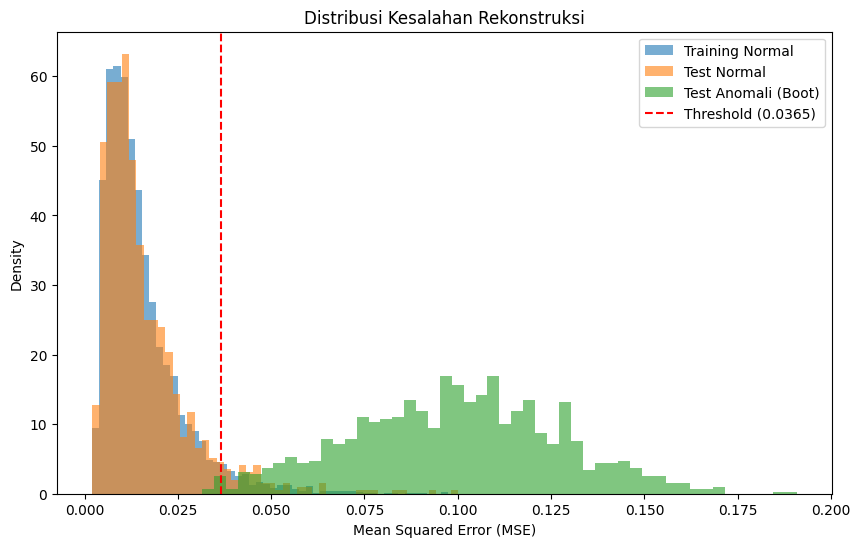

In [8]:
# Hitung error pada data test normal
test_normal_errors = hitung_error(x_test_normal)

# Hitung error pada data test anomali (Ankle boot)
test_anomaly_errors = hitung_error(x_test_anomaly)

# --- Visualisasi Error ---
plt.figure(figsize=(10, 6))
plt.hist(train_errors, bins=50, density=True, label='Training Normal', alpha=0.6)
plt.hist(test_normal_errors, bins=50, density=True, label='Test Normal', alpha=0.6)
plt.hist(test_anomaly_errors, bins=50, density=True, label='Test Anomali (Boot)', alpha=0.6)

# Garis Ambang Batas
plt.axvline(threshold, color='r', linestyle='--', label=f'Threshold ({threshold:.4f})')

plt.title('Distribusi Kesalahan Rekonstruksi')
plt.xlabel('Mean Squared Error (MSE)')
plt.ylabel('Density')
plt.legend()
plt.show()

### 6.1. Akurasi Sederhana

Hitung berapa banyak data anomali yang berhasil dideteksi di atas threshold.

In [9]:
# Hitung True Positives (Anomali yang terdeteksi sebagai Anomali)
anomaly_detected = test_anomaly_errors > threshold
percent_detected = np.sum(anomaly_detected) / len(test_anomaly_errors) * 100

# Hitung False Positives (Normal yang terdeteksi sebagai Anomali)
false_positive = test_normal_errors > threshold
percent_false_positive = np.sum(false_positive) / len(test_normal_errors) * 100

print(f"\n--- Hasil Deteksi ---")
print(f"Persentase Anomali (Boot) yang Terdeteksi: {percent_detected:.2f}%")
print(f"Persentase Kesalahan Positif Palsu (FP) pada T-shirt: {percent_false_positive:.2f}%")


--- Hasil Deteksi ---
Persentase Anomali (Boot) yang Terdeteksi: 99.30%
Persentase Kesalahan Positif Palsu (FP) pada T-shirt: 5.90%


## 7. Penerapan Program untuk Data Baru (Contoh Gambar)

Mari kita coba terapkan model ini pada dua contoh gambar baru: satu normal (T-shirt) dan satu anomali (Ankle boot).


[ Uji Sampel Normal (T-shirt/Top) ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
Error Rekonstruksi: 0.007110
Keputusan: NORMAL (Error <= Threshold)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step

[ Uji Sampel Anomali (Ankle boot) ]
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
Error Rekonstruksi: 0.053347
Keputusan: ANOMALI (Error > Threshold)
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step


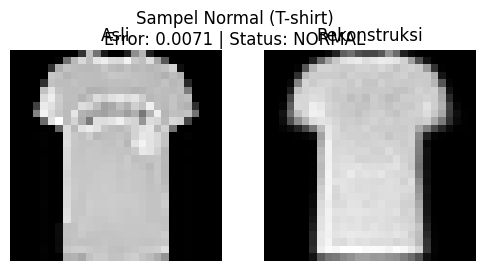

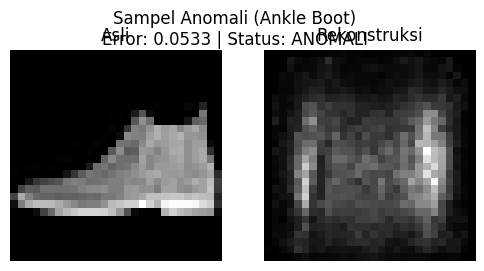

In [10]:
# Pilih satu gambar normal dan satu gambar anomali dari data test
idx_normal = 0
idx_anomaly = 0

sample_normal = x_test_normal[idx_normal].reshape(1, -1)
sample_anomaly = x_test_anomaly[idx_anomaly].reshape(1, -1)

# --- Fungsi Klasifikasi ---
def prediksi_anomali(sample_data, threshold):
    error = hitung_error(sample_data)[0]
    is_anomaly = error > threshold

    print(f"Error Rekonstruksi: {error:.6f}")
    if is_anomaly:
        print(f"Keputusan: ANOMALI (Error > Threshold)")
    else:
        print(f"Keputusan: NORMAL (Error <= Threshold)")

    return error, is_anomaly, autoencoder.predict(sample_data)

# --- Uji Sampel Normal ---
print("\n[ Uji Sampel Normal (T-shirt/Top) ]")
error_n, is_anomaly_n, recon_n = prediksi_anomali(sample_normal, threshold)

# --- Uji Sampel Anomali ---
print("\n[ Uji Sampel Anomali (Ankle boot) ]")
error_a, is_anomaly_a, recon_a = prediksi_anomali(sample_anomaly, threshold)


# --- Visualisasi Hasil Rekonstruksi ---
def plot_reconstruction(original, reconstructed, error, title, is_anomaly):
    fig, axes = plt.subplots(1, 2, figsize=(6, 3))

    original_img = original.reshape(28, 28)
    recon_img = reconstructed.reshape(28, 28)

    axes[0].imshow(original_img, cmap='gray')
    axes[0].set_title(f"Asli")
    axes[0].axis('off')

    axes[1].imshow(recon_img, cmap='gray')
    axes[1].set_title(f"Rekonstruksi")
    axes[1].axis('off')

    status = "ANOMALI" if is_anomaly else "NORMAL"
    fig.suptitle(f"{title}\nError: {error:.4f} | Status: {status}", fontsize=12)
    plt.show()

# Plot Normal
plot_reconstruction(sample_normal, recon_n, error_n, "Sampel Normal (T-shirt)", is_anomaly_n)

# Plot Anomali
plot_reconstruction(sample_anomaly, recon_a, error_a, "Sampel Anomali (Ankle Boot)", is_anomaly_a)

**Penjelasan Hasil Visualisasi:**

*   **Sampel Normal (T-shirt):** Autoencoder berhasil merekonstruksi gambar dengan baik, menghasilkan *Error* yang rendah, di bawah Threshold.
*   **Sampel Anomali (Ankle Boot):** Autoencoder gagal merekonstruksi detail bentuk sepatu, menghasilkan rekonstruksi yang buram dan tidak akurat. Hal ini menyebabkan *Error* yang tinggi, jauh di atas Threshold, dan dengan demikian diklasifikasikan sebagai **ANOMALI**.